# Exercise 5
## GP Optimization of a Toy Problem

In [370]:
#import libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import describe
from scipy.stats import norm
import sobol
import GPy
import optunity

1. Implement f(x,y) and plot its graph

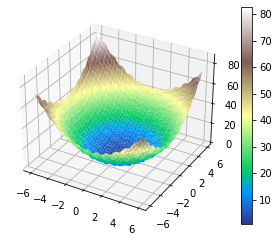

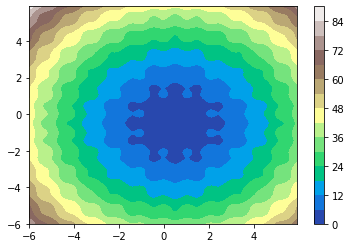

In [371]:
def f(x,y):
    return x**2 - x + y**2 + y - np.cos(2*np.pi*x-np.pi) - np.cos(2*np.pi*y+np.pi) + 2.5

x = np.arange(-6,6,0.1)
y = np.arange(-6,6,0.1)

xx, yy = np.meshgrid(x,y)
fxy = f(xx,yy)

fig, ax = plt.subplots(subplot_kw={"projection":"3d"})

surf = ax.plot_surface(xx,yy,fxy, cmap="terrain")
fig.colorbar(surf)

fig = plt.figure()
h = plt.contourf(x,y,fxy,levels=15,cmap="terrain")
cbar = plt.colorbar()
plt.show()

In [372]:
coord = np.random.rand(2,60)*12 - 6
x = coord[0]
y = coord[1]
f_vals = f(x,y)
describe(f_vals)

DescribeResult(nobs=60, minmax=(2.404914969974628, 67.21212688330486), mean=25.99499909557106, variance=241.95684464871536, skewness=0.2312219939500516, kurtosis=-0.8210701448111886)

In [373]:
#3. Draw set of semi-random locations from a sobol sequence
number_of_samples = 30
parameterUpperLimits = np. array ([6 ,6])
parameterLowerLimits = np. array ([ -6 , -6])
X = np.empty((30,2))

for i in range ( number_of_samples ):
    x,y = sobol.i4_sobol (2 ,i) [0] * ( parameterUpperLimits - parameterLowerLimits ) + parameterLowerLimits
    X[i,:] = [x,y]
    

In [374]:
#4. create initial training set
E = f(X[:,0],X[:,1])[:,None]

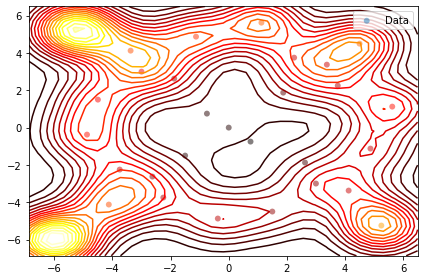

In [375]:
k = GPy.kern.RBF(input_dim=2) + GPy.kern.White(input_dim=2)

m = GPy.models.GPRegression(X,E,k)
m.plot()

def get_u(m):

    def u(x,y,E_best):
        q = np.array([x,y])[None,:]
        E, Var = m.predict(q)
    
        def gamma(q):
            return (E_best - E)/np.sqrt(Var)
    
        return np.sqrt(Var) * (gamma(q) * norm.cdf(gamma(q)) + norm.pdf(gamma(q)))
    
    return u

u = get_u(m)
    

In [376]:
X_pred = np.ones((1,2))*5
m.predict(X_pred)

(array([[10.57734722]]), array([[2.79780591]]))

['grid search', 'random search', 'nelder-mead', 'sobol', 'particle swarm']


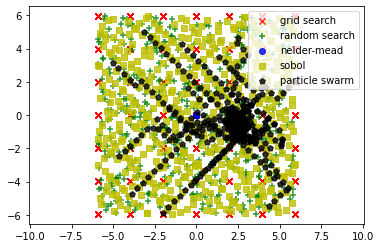

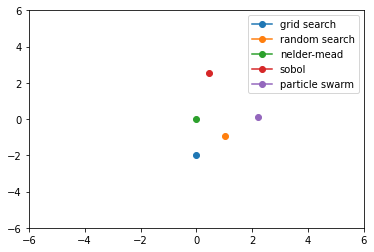

In [377]:
#6. Optimization using sobol

solvers = optunity.available_solvers()
print(solvers)

optimal_params = dict([(s, []) for s in solvers])

logs = {}
for solver in solvers:
    pars, details, _ = optunity.maximize(u, num_evals=500, x=[-6, 6], y=[-6,6], E_best=[0, 100], solver_name=solver)
    logs[solver] = np.array([details.call_log['args']['x'],
                             details.call_log['args']['y']])
    
    optimal_params[solver] = pars
    
# make sure different traces are somewhat visually separable
colors =  ['r', 'g', 'b', 'y', 'k', 'y', 'r', 'g']
markers = ['x', '+', 'o', 's', 'p', 'x', '+', 'o']

# compute contours of the objective function
delta = 0.025
x = np.arange(-5.0, 5.0, delta)
y = np.arange(-5.0, 5.0, delta)
x, y = np.meshgrid(x, y)
Z = f(x, y)

plt.figure()
for i, solver in enumerate(solvers):
    plt.scatter(logs[solver][0,:], logs[solver][1,:], c=colors[i], marker=markers[i], alpha=0.80)

plt.xlim([-6, 6])
plt.ylim([-6, 6])
plt.axis('equal')
plt.legend(solvers)
plt.show()

plt.figure()
for i, solver in enumerate(solvers):
    plt.plot(optimal_params[solver]["x"], optimal_params[solver]["y"], marker="o", label="solver")
plt.legend(solvers)
plt.xlim(-6,6)
plt.ylim(-6,6)
plt.show()


7. From now on we only consider the random search solver. 

{'dataplot': [<matplotlib.collections.PathCollection at 0x7f8f04edf850>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x7f8f0411d130>]}

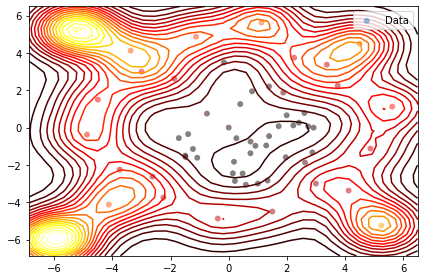

In [378]:
q = np.empty((1,2))
q[0,0] = optimal_params[solver]["x"]
q[0,1] = optimal_params[solver]["y"]

fq = m.predict(q)[0][0][0]

n_iterations = 30
for i in range(n_iterations):
    
    X = np.concatenate((X,q), axis=0)
    E = np.concatenate((E,[[fq]]), axis=0)
    m = GPy.models.GPRegression(X,E,k)
    u = get_u(m)
    
    pars, details, _ = optunity.maximize(u, num_evals=500, x=[-6, 6], y=[-6,6], E_best=[0, 100], solver_name="random search")
    logs[solver] = np.array([details.call_log['args']['x'],
                             details.call_log['args']['y']])

    q[0,0] = pars["x"]
    q[0,1] = pars["y"]
    fq = m.predict(q)[0][0][0]

m.plot()

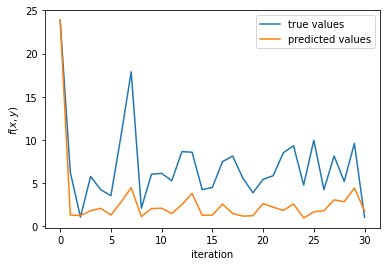

In [379]:
plt.figure()
plt.plot(f(X[29:,0],X[29:,1]), label="true values")
plt.plot(E[29:], label="predicted values")
plt.xlabel("iteration")
plt.ylabel("$f(x,y)$")
plt.legend()
plt.show()

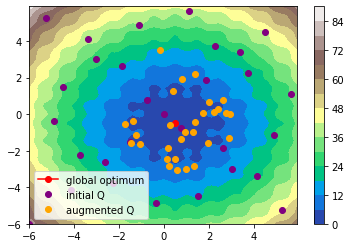

In [380]:
x = np.arange(-6,6,0.1)
y = np.arange(-6,6,0.1)

xx, yy = np.meshgrid(x,y)
fxy = f(xx,yy)

fig = plt.figure()
h = plt.contourf(x,y,fxy,levels=15,cmap="terrain")
cbar = plt.colorbar()
plt.plot([.5], [-.5], color="red", marker="o", label="global optimum")
plt.plot(X[:30,0],X[:30,1], color="purple", marker="o", label="initial Q", linestyle="None")
plt.plot(X[30:,0],X[30:,1], color="Orange", marker="o", label="augmented Q", linestyle="None")
plt.legend()
plt.show()

We observe that the initial training set is more or less uniformly distributed. The added training points are strongly concentrated around the global optimum.

 /Users/aaron/opt/anaconda3/lib/python3.8/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x7f8ed18ccf40>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x7f8ed18cc340>]}

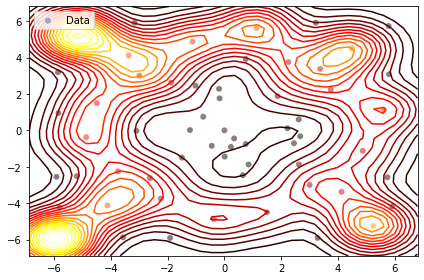

In [381]:
def get_var(m):
    def var(x,y):
        return m.predict(np.array([[x,y]]))[1][0][0]
    return var

#reset X, E
E = E[:30,:]
X = X[:30,:]

q = np.empty((1,2))
q[0,0] = optimal_params[solver]["x"]
q[0,1] = optimal_params[solver]["y"]

fq = m.predict(q)[0][0][0]

n_iterations = 30
for i in range(n_iterations):
    
    X = np.concatenate((X,q), axis=0)
    E = np.concatenate((E,[[fq]]), axis=0)
    m = GPy.models.GPRegression(X,E,k)
    
    if (i%2==0):
        u = get_u(m)
    
        pars, details, _ = optunity.maximize(u, num_evals=500, x=[-6, 6], y=[-6,6], E_best=[0, 100], solver_name="random search")
        logs[solver] = np.array([details.call_log['args']['x'],
                                 details.call_log['args']['y']])
        
    else:
        u = get_var(m)
        
        pars, details, _ = optunity.maximize(u, num_evals=500, x=[-6, 6], y=[-6,6], solver_name="random search")
        logs[solver] = np.array([details.call_log['args']['x'],
                                 details.call_log['args']['y']])
        
    q[0,0] = pars["x"]
    q[0,1] = pars["y"]
    fq = m.predict(q)[0][0][0]

m.plot()

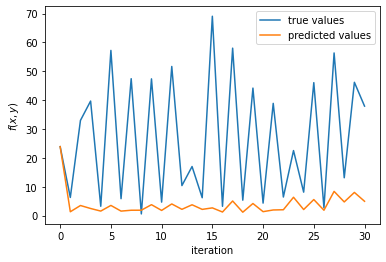

In [382]:
plt.figure()
plt.plot(f(X[29:,0],X[29:,1]), label="true values")
plt.plot(E[29:], label="predicted values")
plt.xlabel("iteration")
plt.ylabel("$f(x,y)$")
plt.legend()
plt.show()

We see that the true values jump up and down periodically. The reason is the alternation hyperparameter selection scheme.

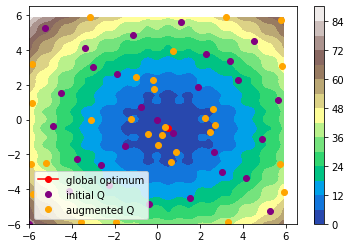

In [383]:
x = np.arange(-6,6,0.1)
y = np.arange(-6,6,0.1)

xx, yy = np.meshgrid(x,y)
fxy = f(xx,yy)

fig = plt.figure()
h = plt.contourf(x,y,fxy,levels=15,cmap="terrain")
cbar = plt.colorbar()
plt.plot([.5], [-.5], color="red", marker="o", label="global optimum")
plt.plot(X[:30,0],X[:30,1], color="purple", marker="o", label="initial Q", linestyle="None")
plt.plot(X[30:,0],X[30:,1], color="Orange", marker="o", label="augmented Q", linestyle="None")
plt.legend()
plt.show()

We see that there is a concentration of training points around the global minimum. These points correspond to the maximum expected improvement scheme. Additionally there are points that fill the largest gaps between existing training points. These correspond to the maximum variance scheme.
Remark: 11. has already been done because we plotted the prediction for f(x,y) in each task.

12. The requirements for f(x,y) are that it has a minimum and that it fulfills the requirements of the optimization methods from optunity. Additionally, the function likely has to fulfill some regularity constraints (e.g. continuous or differentiable).